In [78]:
!pip install scikit-plot
!pip install WordCloud
!pip install xgboost
!pip install lightgbm
!pip install textblob

In [79]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

## Import DataSet

In [4]:
df = pd.read_csv("processed_reviews_split_surnamesB_minimal.csv")
print(df.shape)
df.head(3)

(32918, 5)


,review_id,text,verified,review_score,product_category
0,product_review_000000,I really like this game. I play MMO's casually...,False,4.0,video_games
1,product_review_000001,Got this for my niece for her Skylanders game ...,True,5.0,video_games
2,product_review_000002,"Believe me, many people in America, hell, in t...",False,5.0,video_games


In [5]:
df.groupby(['review_score', 'product_category'])['product_category'].count()

review_score  product_category   
-1.0          musical_instruments      296
              video_games              610
 1.0          musical_instruments      320
              video_games             1501
 2.0          musical_instruments      334
              video_games             1178
 3.0          musical_instruments      740
              video_games             2302
 4.0          musical_instruments     1743
              video_games             4276
 5.0          musical_instruments     6731
              video_games            11981
Name: product_category, dtype: int64

## # Text Features

In [6]:
text_df = df[['text', 'product_category','review_score']]
text_df.head()

,text,product_category,review_score
0,I really like this game. I play MMO's casually...,video_games,4.0
1,Got this for my niece for her Skylanders game ...,video_games,5.0
2,"Believe me, many people in America, hell, in t...",video_games,5.0
3,"believe it or not, woman like shoot em up game...",video_games,5.0
4,This was meant to be use on my PC so please fa...,video_games,5.0


## Data Preprocessing

## Drop Null Value

In [7]:
text_df.isna().sum()

text                 20
product_category    906
review_score          0
dtype: int64

In [8]:
text_df.dropna(inplace=True)

In [9]:
text_df.isna().sum()

text                0
product_category    0
review_score        0
dtype: int64

In [10]:
text_df.head()

,text,product_category,review_score
0,I really like this game. I play MMO's casually...,video_games,4.0
1,Got this for my niece for her Skylanders game ...,video_games,5.0
2,"Believe me, many people in America, hell, in t...",video_games,5.0
3,"believe it or not, woman like shoot em up game...",video_games,5.0
4,This was meant to be use on my PC so please fa...,video_games,5.0


## Target review product category

In [11]:
text_df['product_category'].unique()

array(['video_games', 'musical_instruments'], dtype=object)

In [12]:
text_df["product_category"].replace({"video_games": "videogames", "musical_instruments": "musicalinstruments"}, inplace=True)
text_df

,text,product_category,review_score
0,I really like this game. I play MMO's casually...,videogames,4.0
1,Got this for my niece for her Skylanders game ...,videogames,5.0
2,"Believe me, many people in America, hell, in t...",videogames,5.0
3,"believe it or not, woman like shoot em up game...",videogames,5.0
4,This was meant to be use on my PC so please fa...,videogames,5.0
...,...,...,...
32913,It is not my size but it work great. Nothing w...,musicalinstruments,5.0
32914,"THIS THING IS OK,YOU HAVE TO HIT THEM PRETTY G...",musicalinstruments,3.0
32915,A Classic seriously under the radar! If your a...,videogames,5.0
32916,This game is just wonderful.\nHavent had a sin...,videogames,5.0


In [13]:
text_df['product_category'].value_counts(normalize=True)

videogames            0.682556
musicalinstruments    0.317444
Name: product_category, dtype: float64

## Text Length

In [14]:
text_df['Review_length'] = text_df['text'].apply(len)
print(text_df.shape)
text_df.head()

(31993, 4)


,text,product_category,review_score,Review_length
0,I really like this game. I play MMO's casually...,videogames,4.0,1332
1,Got this for my niece for her Skylanders game ...,videogames,5.0,124
2,"Believe me, many people in America, hell, in t...",videogames,5.0,780
3,"believe it or not, woman like shoot em up game...",videogames,5.0,253
4,This was meant to be use on my PC so please fa...,videogames,5.0,352


In [15]:
text_df['Review_length'].describe()

count    31993.000000
mean       646.285250
std       1150.851127
min          4.000000
25%        109.000000
50%        253.000000
75%        684.000000
max      28437.000000
Name: Review_length, dtype: float64

<AxesSubplot:xlabel='Review_length', ylabel='Density'>

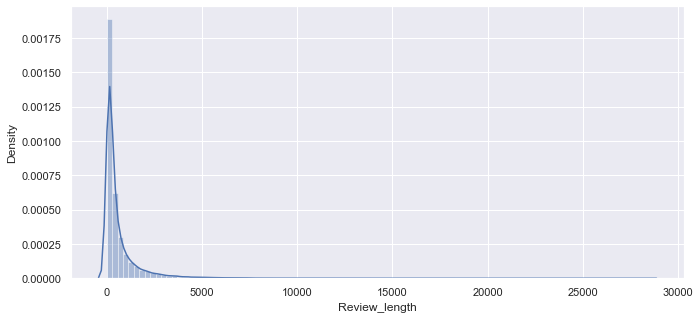

In [16]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

## Exclamation mark counter

In [17]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

text_df['count_exc'] = text_df['text'].apply(count_exclamation_mark)
text_df.head(5)

,text,product_category,review_score,Review_length,count_exc
0,I really like this game. I play MMO's casually...,videogames,4.0,1332,1
1,Got this for my niece for her Skylanders game ...,videogames,5.0,124,0
2,"Believe me, many people in America, hell, in t...",videogames,5.0,780,2
3,"believe it or not, woman like shoot em up game...",videogames,5.0,253,0
4,This was meant to be use on my PC so please fa...,videogames,5.0,352,6


In [18]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    31993.000000
mean         0.813397
std          2.401459
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
80%          1.000000
max        120.000000
Name: count_exc, dtype: float64

<AxesSubplot:>

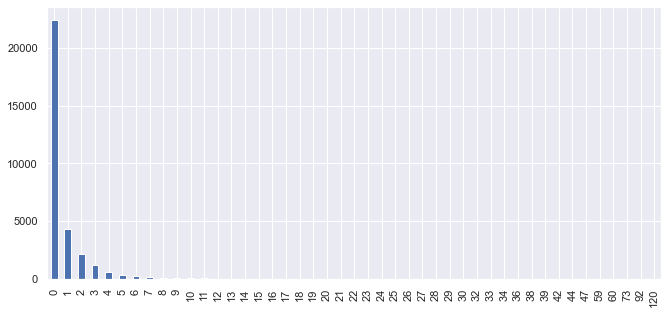

In [19]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [20]:
text_df[text_df['count_exc']== 120].index

Int64Index([11628], dtype='int64')

In [21]:
text_df['text'][11628]

"If you are grownup like me (not a little babay or youngun) than you remeber the oldin day and they have a movie that come out called GHOSTBUSSERS!!!!  In ghostbussers Bill Maray and Dan Akroid and Haruld Rams play science DWEEBS who get fired from they science job and have to start bustin' ghosts like GANGSTAS all over the town they live in which I think is Chicago which is the BIG CITY.  They shoot lazers at ghosts and go all around sayin BUSSIN MAKE ME FEEEL GOOD which was also the tittle of teh songs sung by Ray Parkman Junior for the movie which was a HIT SONG and was badass!!!!!!!!\n\nWell now you can play as a ghosbuster and bust slimers and ghosts and witches and warlocks and FEEL GOOD just like ray Parkman predict you would!!!!!!!!!!\n\nGhostbussers is teh new game from Activevision and it won't just bust your wallet LOLOLOL!!!!!  In it you plays as a new recruit who want to bust some ghosts and man do you ever get to just like in the olden times movie.  In the begining you st

In [22]:
text_df['Polarity'] = text_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,text,product_category,review_score,Review_length,count_exc,Polarity
0,I really like this game. I play MMO's casually...,videogames,4.0,1332,1,0.098468
1,Got this for my niece for her Skylanders game ...,videogames,5.0,124,0,0.400000
2,"Believe me, many people in America, hell, in t...",videogames,5.0,780,2,0.079383
3,"believe it or not, woman like shoot em up game...",videogames,5.0,253,0,0.263773
4,This was meant to be use on my PC so please fa...,videogames,5.0,352,6,0.600000


<AxesSubplot:ylabel='Frequency'>

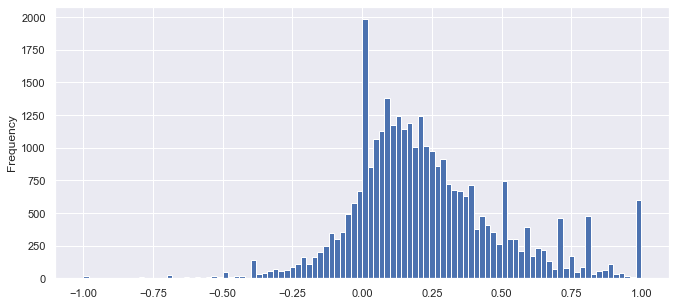

In [23]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [24]:
text_prep = text_df.copy()

### Dropping punctuation

In [25]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [27]:
text_prep['text'] = text_prep['text'].apply(punctuation_removal)
text_prep['text'].head()

0    I really like this game I play MMOs casually I...
1    Got this for my niece for her Skylanders game ...
2    Believe me many people in America hell in the ...
3    believe it or not woman like shoot em up games...
4    This was meant to be use on my PC so please fa...
Name: text, dtype: object

### Removing stopwords

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EXCEL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stop = stopwords.words('english')
stop.append('I')
stop_words = []

text_prep['text'] = text_prep['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
text_prep.head()

,text,product_category,review_score,Review_length,count_exc,Polarity
0,really like game play MMOs casually played WoW...,videogames,4.0,1332,1,0.098468
1,Got niece Skylanders game cheaper target Happy...,videogames,5.0,124,0,0.400000
2,Believe many people America hell world play go...,videogames,5.0,780,2,0.079383
3,believe woman like shoot em games nice one bes...,videogames,5.0,253,0,0.263773
4,This meant use PC please factor In view like U...,videogames,5.0,352,6,0.600000


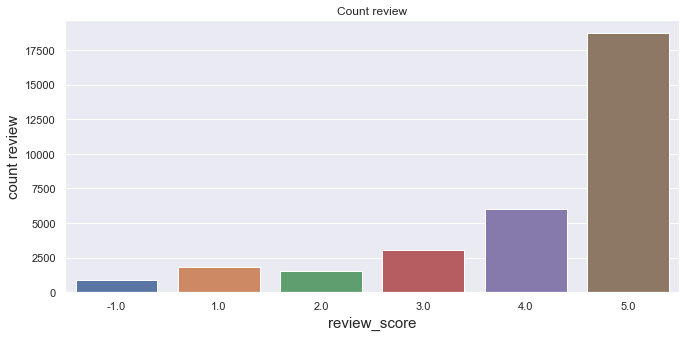

In [30]:
# Count of 0 reviews and 1 reviews 
ax=sns.countplot(x="review_score", data=text_prep)
ax.set(xlabel='review_score', ylabel='count review',title='Count review')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()

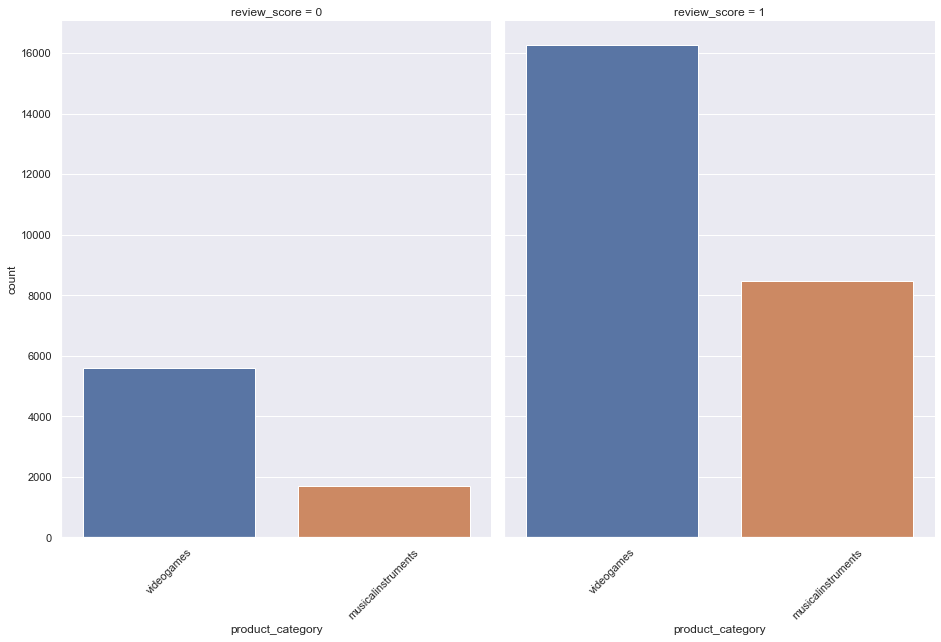

In [76]:
g = sns.catplot(x="product_category", col="review_score", data=text_prep, kind="count", height=8, aspect=.8, col_wrap=3)
g.set_xticklabels(rotation=45)
plt.show()

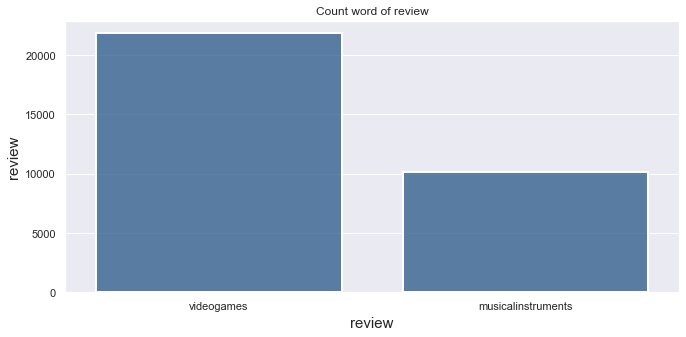

In [32]:
# Visualization of reivews
ax = sns.countplot(x="product_category", data=text_prep,facecolor=(.1, .3, .5, .7),linewidth=2)
ax.set(xlabel='review', ylabel='review',title='Count word of review')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()

In [33]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EXCEL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\EXCEL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

text_prep['text'] = text_prep['text'].apply(adj_collector)
text_prep['text'].head(7)

0    like played bored quit got bored got liked don...
1                                          niece Happy
2    many let tell ya gruesome awesome contains sho...
3    believe nice black great great got fast amazon...
4    uses battery detect works remote perfect Had h...
5    Nice solid fi evolved single graphics arent to...
6    comes talking theres say isnt said classic go ...
Name: text, dtype: object

## Lemmetization

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EXCEL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
lemmatizer = WordNetLemmatizer()

# lemmatize string
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas



lemmatized_words = text_prep.apply(lambda row: lemmatize_word(row['text']),axis=1)
#text = 'Fun if you havent played any of the games before!. Fun!'
lemmatized_words

0        [like, play, bore, quit, get, bore, get, like,...
1                                           [niece, Happy]
2        [many, let, tell, ya, gruesome, awesome, conta...
3        [believe, nice, black, great, great, get, fast...
4        [use, battery, detect, work, remote, perfect, ...
                               ...                        
32913                                 [great, wrong, dual]
32914                                [THIS, THING, IS, OK]
32915    [radar, new, make, frighten, play, interactive...
32916    [wonderful, single, meet, play, require, run, ...
32917    [Have, wonder, see, bunch, grunt, namecalling,...
Length: 31993, dtype: object

## Devided Score Value

In [37]:
def apply_sentiment(review_score):
    if(review_score <=3.0 ):
        return 0
    else:
        return 1
    
text_prep['review_score'] = text_prep['review_score'].apply(apply_sentiment)
# df.drop(['Rating'],axis = 1, inplace = True)

In [38]:
df_zero = text_prep[text_prep['review_score']==0]
df_one = text_prep[text_prep['review_score']==1]

<AxesSubplot:ylabel='Density'>

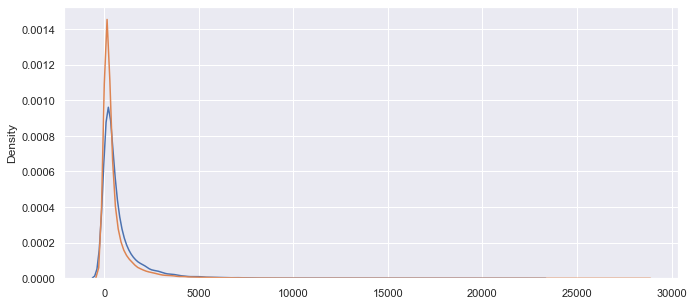

In [39]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [40]:
pos_df = text_prep[text_prep.review_score== 1]
neg_df = text_prep[text_prep.review_score== 0]

In [41]:
pos_words =[]

for review in pos_df.text:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:400]

'like played bored quit got bored got liked dont reached make past maxed sitting pressing next takes puts great recommend likes wants get possible much level know need finding isnt hard add stunning able high mid huge nice look great nice try get starter picks niece Happy many let tell ya gruesome awesome contains shooting sneaking dont startle single become repetitive solved making single single o'

In [42]:
neg_words = []

for review in neg_df.text:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'good little release looks real nice attach top small hard attached going leave forget great take strap takes looks real nice attach top starting populated sasaf oihhgdsgf thirtysomething wearing running mutated take offending come next running done trying deal failing banned many legitimate admission stemmed scripted needed finish camped swinging get hit quests impossible complete unplayable overr'

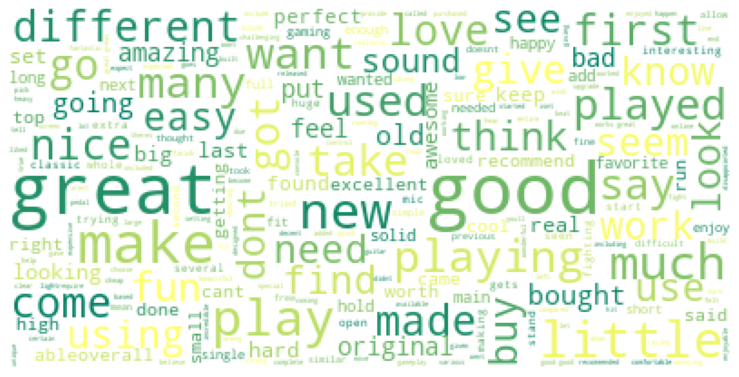

In [80]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

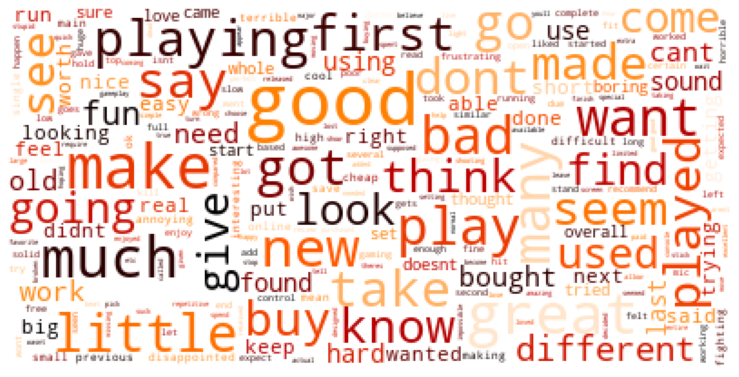

In [81]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### TF-IDF with split

In [43]:
vectorizer = TfidfVectorizer(max_features = 30000, ngram_range = (1,3), analyzer = 'char')
X = vectorizer.fit_transform(text_prep['text'])
y = text_prep['review_score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 40)

In [44]:
y_train.value_counts(normalize=True)

1    0.772486
0    0.227514
Name: review_score, dtype: float64

In [45]:
y_test.value_counts(normalize=True)

1    0.773246
0    0.226754
Name: review_score, dtype: float64

In [46]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [47]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

In [48]:
test_predictions = svc_model.predict(X_test)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
      0     1
0   971   480
1  1253  3695

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.67      0.53      1451
           1       0.89      0.75      0.81      4948

    accuracy                           0.73      6399
   macro avg       0.66      0.71      0.67      6399
weighted avg       0.78      0.73      0.75      6399



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

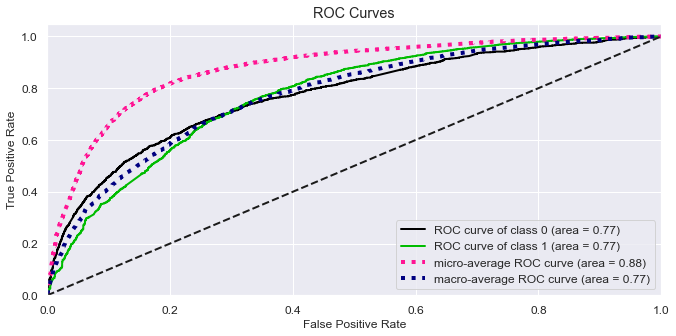

In [49]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test)) 

### SVC evoluation

In [50]:
r = 'Music is bad'
p = vectorizer.transform([r])
svc_model.predict(p)

array([0], dtype=int64)

In [51]:
r = 'song is very good'
p = vectorizer.transform([r])
svc_model.predict(p)

array([1], dtype=int64)

In [52]:
r = 'I really like this game'
p = vectorizer.transform([r])
svc_model.predict(p)

array([1], dtype=int64)

In [53]:
r = 'It looks differnet from gane image that uploaded on website  '
p = vectorizer.transform([r])
svc_model.predict(p)

array([1], dtype=int64)

In [54]:
r = 'Instrument condition and color is nice at outside because of delivery'
p = vectorizer.transform([r])
svc_model.predict(p)

array([1], dtype=int64)

In [55]:
r = 'I give very rating for this game product'
p = vectorizer.transform([r])
svc_model.predict(p)

array([0], dtype=int64)

In [56]:
r = 'I give the great score for music instrument seller '
p = vectorizer.transform([r])
svc_model.predict(p)

array([1], dtype=int64)

In [57]:
r = 'game is not working properly, due to damaged'
p = vectorizer.transform([r])
svc_model.predict(p)

array([0], dtype=int64)

In [58]:
r = 'hurrey, I finally i get m PS5 and give the good rating for it'
p = vectorizer.transform([r])
svc_model.predict(p)

array([0], dtype=int64)

In [59]:
r = 'I order one set of drum stick, one of stick is band from middle'
p = vectorizer.transform([r])
svc_model.predict(p)

array([0], dtype=int64)

In [60]:
vectorizer = TfidfVectorizer(max_features = 30000, ngram_range = (1,3), analyzer = 'char')
X1 = vectorizer.fit_transform(text_prep['text'])
y1 = text_prep['product_category']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size = 0.2, random_state = 40)

In [61]:
lr_model = LogisticRegression(class_weight='balanced', random_state=111, solver='lbfgs',C=1.0)



gs_lr_model = GridSearchCV(lr_model, param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, cv=5, scoring='roc_auc')



gs_lr_model.fit(X_train1, y_train1)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [62]:
gs_lr_model.best_params_

{'C': 5.0}

In [63]:
test_predictions1 = gs_lr_model.predict(X_test1)
print(report(y_test1, test_predictions1, gs_lr_model.classes_ ))

Confusion Matrix:
                    musicalinstruments  videogames
musicalinstruments                1739         325
videogames                         887        3448

Classification Report:
                    precision    recall  f1-score   support

musicalinstruments       0.66      0.84      0.74      2064
        videogames       0.91      0.80      0.85      4335

          accuracy                           0.81      6399
         macro avg       0.79      0.82      0.80      6399
      weighted avg       0.83      0.81      0.82      6399



<AxesSubplot:title={'center':'ROC Curves - Logistic Regression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

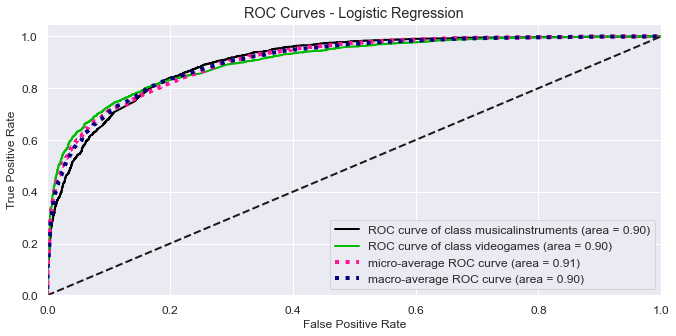

In [64]:
skplt.metrics.plot_roc(y_test1, gs_lr_model.predict_proba(X_test1), title='ROC Curves - Logistic Regression')

### LOGISTIC evoluation

In [65]:
r = 'Music sounds'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['musicalinstruments'], dtype=object)

In [66]:
r = 'god of war game is the best action game'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['videogames'], dtype=object)

In [67]:
r = 'Ps4 is lower processor campared to ps5'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['videogames'], dtype=object)

In [68]:
r = 'I started drum when I met my idle'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['musicalinstruments'], dtype=object)

In [69]:
r = 'powerfull sound in game'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['videogames'], dtype=object)

In [70]:
r = 'Love song is the best using piano'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['musicalinstruments'], dtype=object)

In [71]:
r = 'violin and recorder combination is deadly in song'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['musicalinstruments'], dtype=object)

In [72]:
r = 'This is a fantastic game and the graphics are brilliant on Xbox one x, this is a must for any car racing gamer as a gift this Christmas'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['videogames'], dtype=object)

In [73]:
r = 'the graphics are fantastic. One would think that they were watching a film, such is the degree of realism.'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['videogames'], dtype=object)

In [74]:
r = 'Trumpet and flue is my favorite instrument'
p = vectorizer.transform([r])
gs_lr_model.predict(p)

array(['musicalinstruments'], dtype=object)

### Export CSV file

In [75]:
text_prep.to_csv(r'C:/Users/EXCEL/Downloads/processed.csv')